## This script will take in the drifting gratings and output the total energy.

1) First Check: confirm that the stimuli input to the pyramid match the experiment and have padding
2) Second Check: confirm the SF channel output matches the stimuli
3) Compare the energy across SF channels and stimuli

In [1]:
import contextlib
import itertools
import os
import ipdb
import sys
import json
from PIL import Image
import pandas as pd
import seaborn as sns
import cv2
from itertools import product
from matplotlib import colors
import copy

from helper_functions import pyrmodel
from helper_functions import utils_image
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from tqdm.auto import tqdm

import plenoptic as po
from plenoptic.simulate import SteerablePyramidFreq
from plenoptic.tools.data import to_numpy

In [2]:
# this notebook uses torchvision, which is an optional dependency.
# if this fails, install torchvision in your plenoptic environment
# and restart the notebook kernel.
try:
    import torchvision
except ModuleNotFoundError:
    raise ModuleNotFoundError(
        "optional dependency torchvision not found!"
        " please install it in your plenoptic environment "
        "and restart the notebook kernel"
    )
import torchvision.transforms as transforms

dtype = torch.float32

# handle for tensors (use GPU if possible)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# magic commands to auto-reload imported modules anytime they are changed on disk
%load_ext autoreload
%autoreload 2

# so that relative sizes of axes created by po.imshow and others look right
plt.rcParams["figure.dpi"] = 72

%matplotlib inline

plt.rcParams["animation.html"] = "html5"
# use single-threaded ffmpeg for animation writer
plt.rcParams["animation.writer"] = "ffmpeg"
plt.rcParams["animation.ffmpeg_args"] = ["-threads", "1"]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# make the stimulus diameter 870 pixels, and image 896 pixels, padding of 13 pixels per edge
# stimulus diameter is 24.4 deg, 870 pixels. So adjust degrees based on this ratio.

img_size = 896                                     # limited by sqrt n_sf x ;
exp_stim_diamDeg = 24.4                            # needed to make stimulus approx the same as in experiment

x = int(np.round(img_size*0.85))                   # compute 97% of the img_size
x = x if x % 2 == 0 else x+1                       # if its odd, subtract 1 to make it even

img_size_nonPadded = x
pixpdeg = x/exp_stim_diamDeg
padded_img_degrees = img_size/pixpdeg              # derive degrees of padded image

############################################################################

n_ori = 4
n_sf = 6


my_model = pyrmodel.SteerablePyramidSF(n_ori=n_ori,
                                       n_sf=n_sf,
                                       img_size=img_size,
                                       img_degrees=padded_img_degrees,
                                       is_complex=True,
                                       downsample=False,
                                       tight_frame=True,
                                       device='cpu')


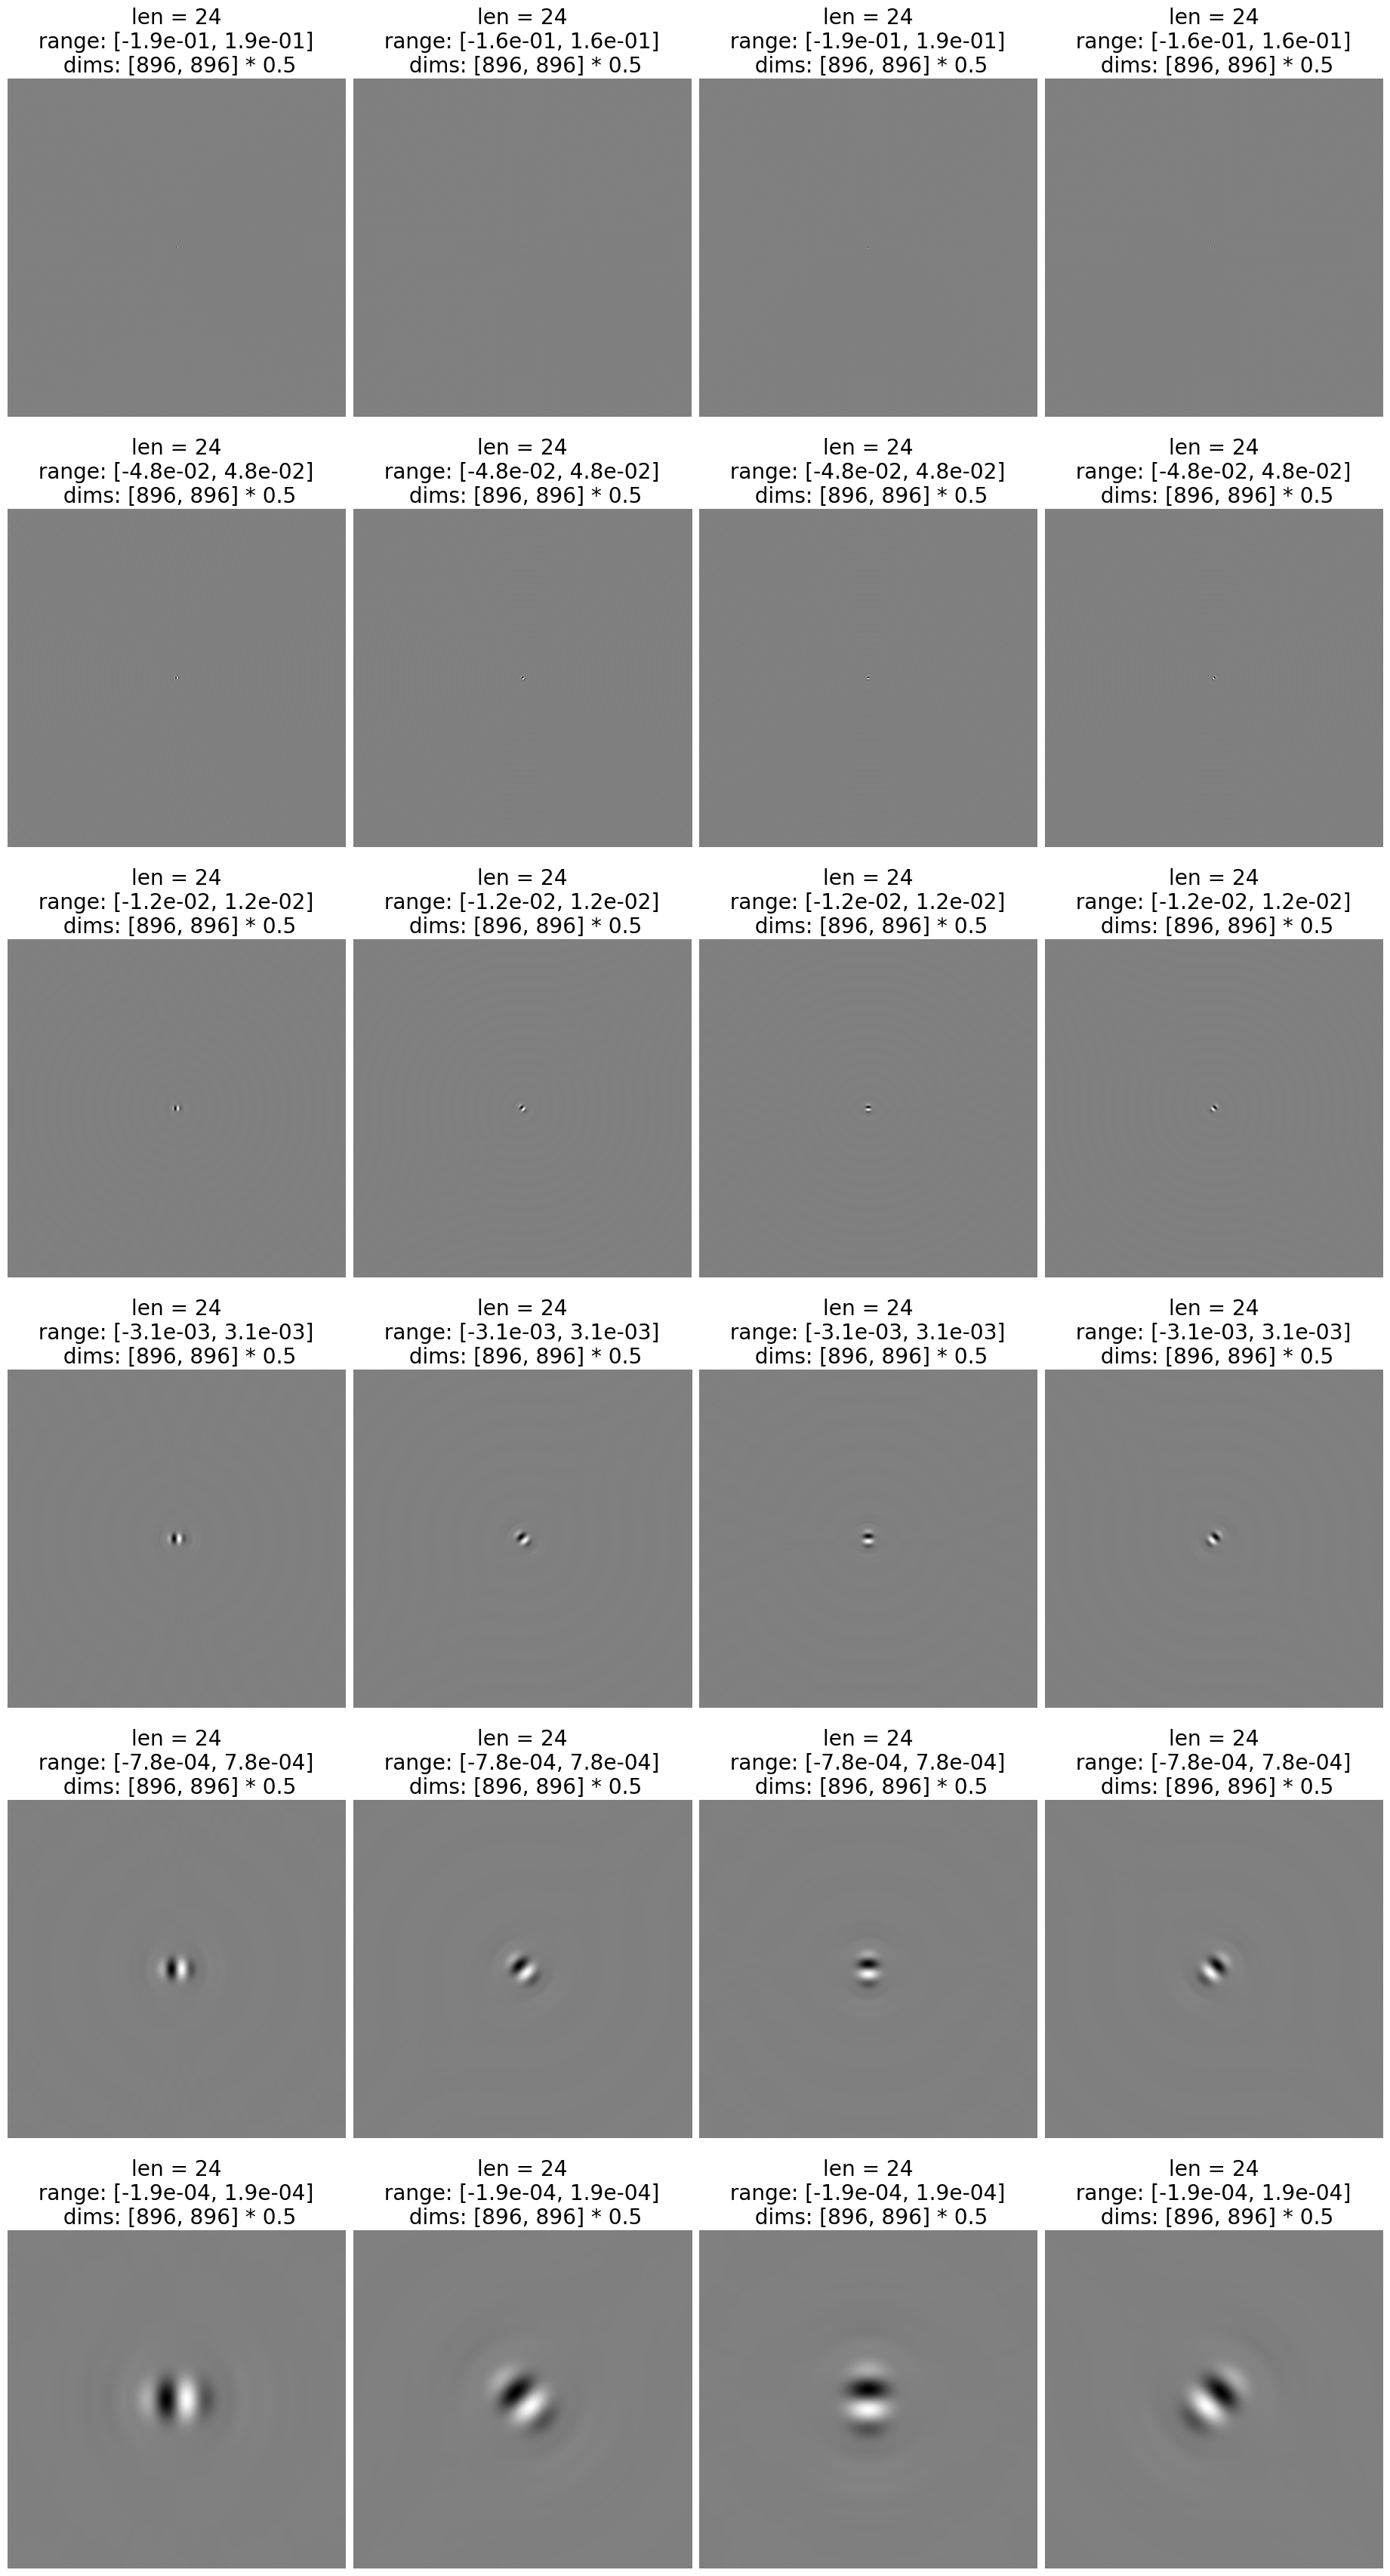

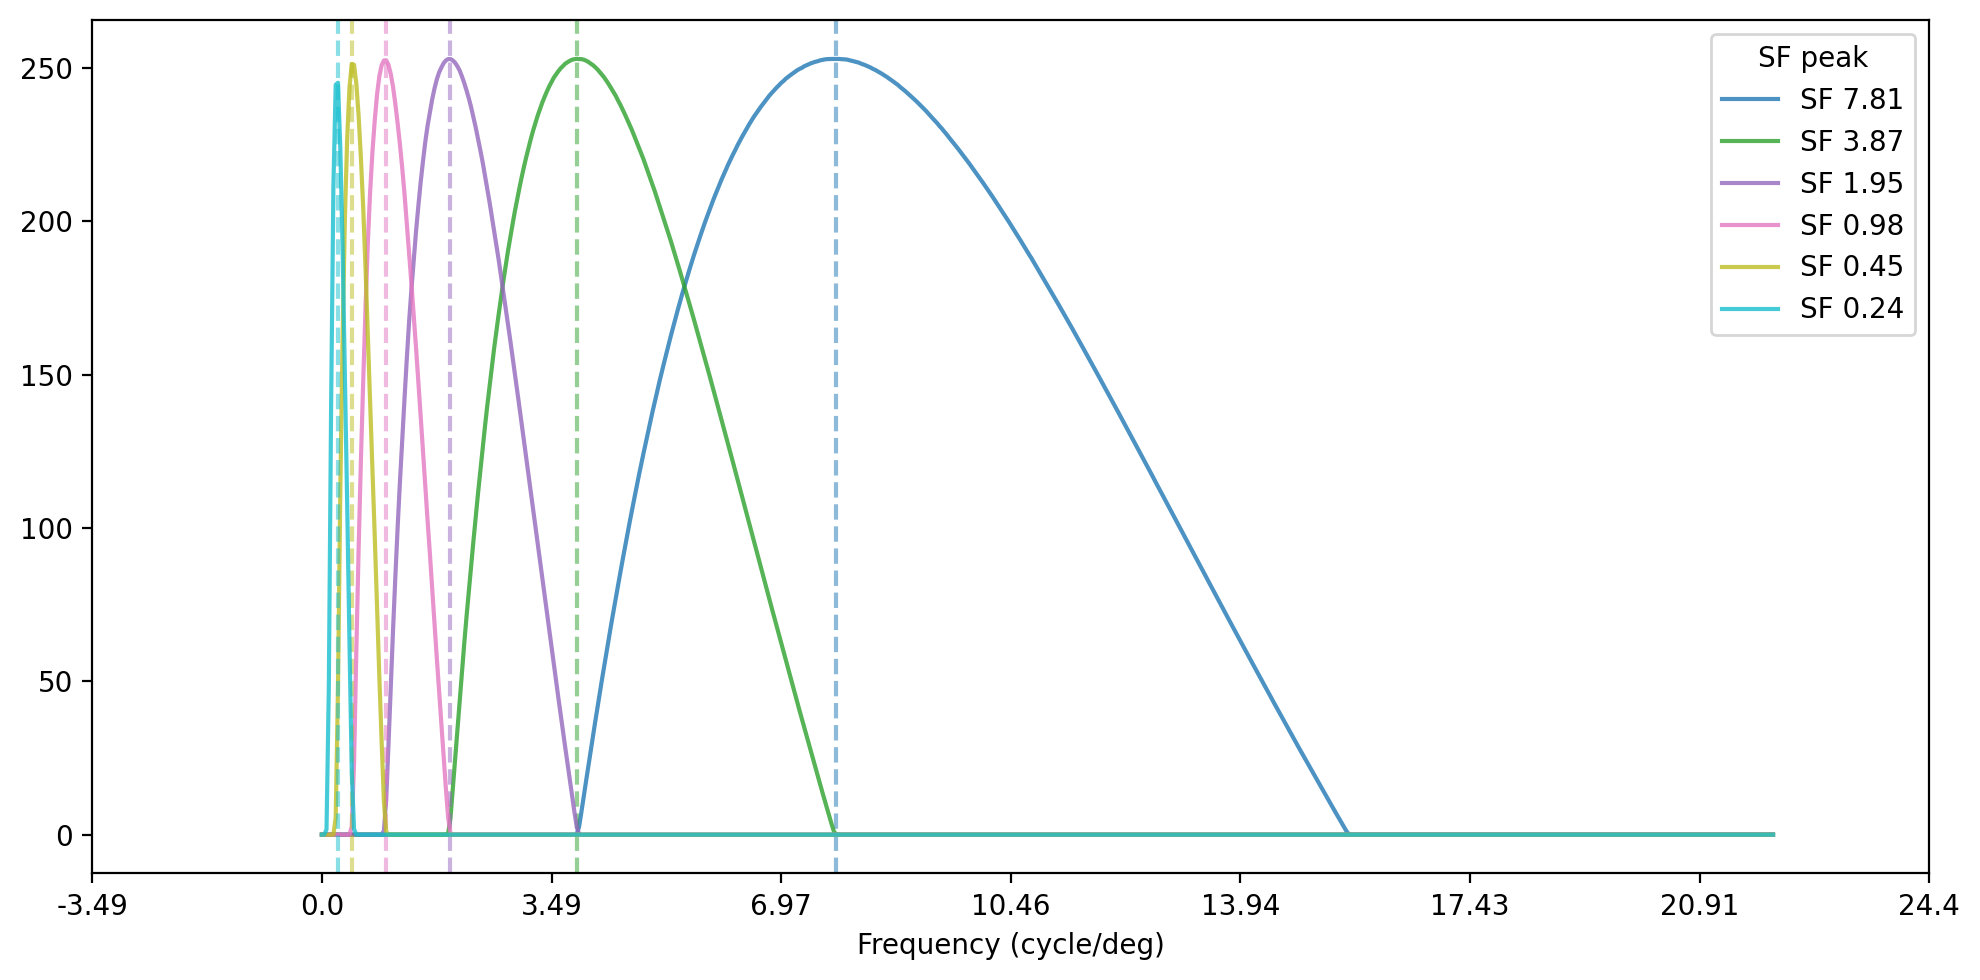

In [4]:
# this depends on img_size (.25, .125, 0.06, 0.03, 0.015, 0.006)
# also changes with n_sf (more low SF ch, and minimally with n_ori)

filter_sf_tunings = my_model.get_filter_sf_tunings()
colors = plt.cm.tab10(np.linspace(0, 1, n_sf))
fig, axes = plt.subplots(1, 1, figsize=(10, 5), dpi=200)
chSFs = {}
for i, sf in enumerate(range(n_sf)):
    k = np.where(filter_sf_tunings[sf] == filter_sf_tunings[sf].max())[0][0]
    chSFs[i] = np.round(k/my_model.img_degrees,2)
    axes.plot(range(filter_sf_tunings.shape[-1]), 
              filter_sf_tunings[sf], 
              alpha=0.8, 
              label=f'SF {np.round(k/my_model.img_degrees,2)}', 
              color=colors[sf])
    axes.axvline(k, color=colors[sf], linestyle='--', alpha=0.5)

axes.set_xlabel('Frequency (cycle/deg)')
current = axes.get_xticks()
axes.set_xticks(current)
new = current/my_model.img_degrees
axes.set_xticklabels(np.round(new,2))
axes.legend(title='SF peak', loc='best')
plt.tight_layout();


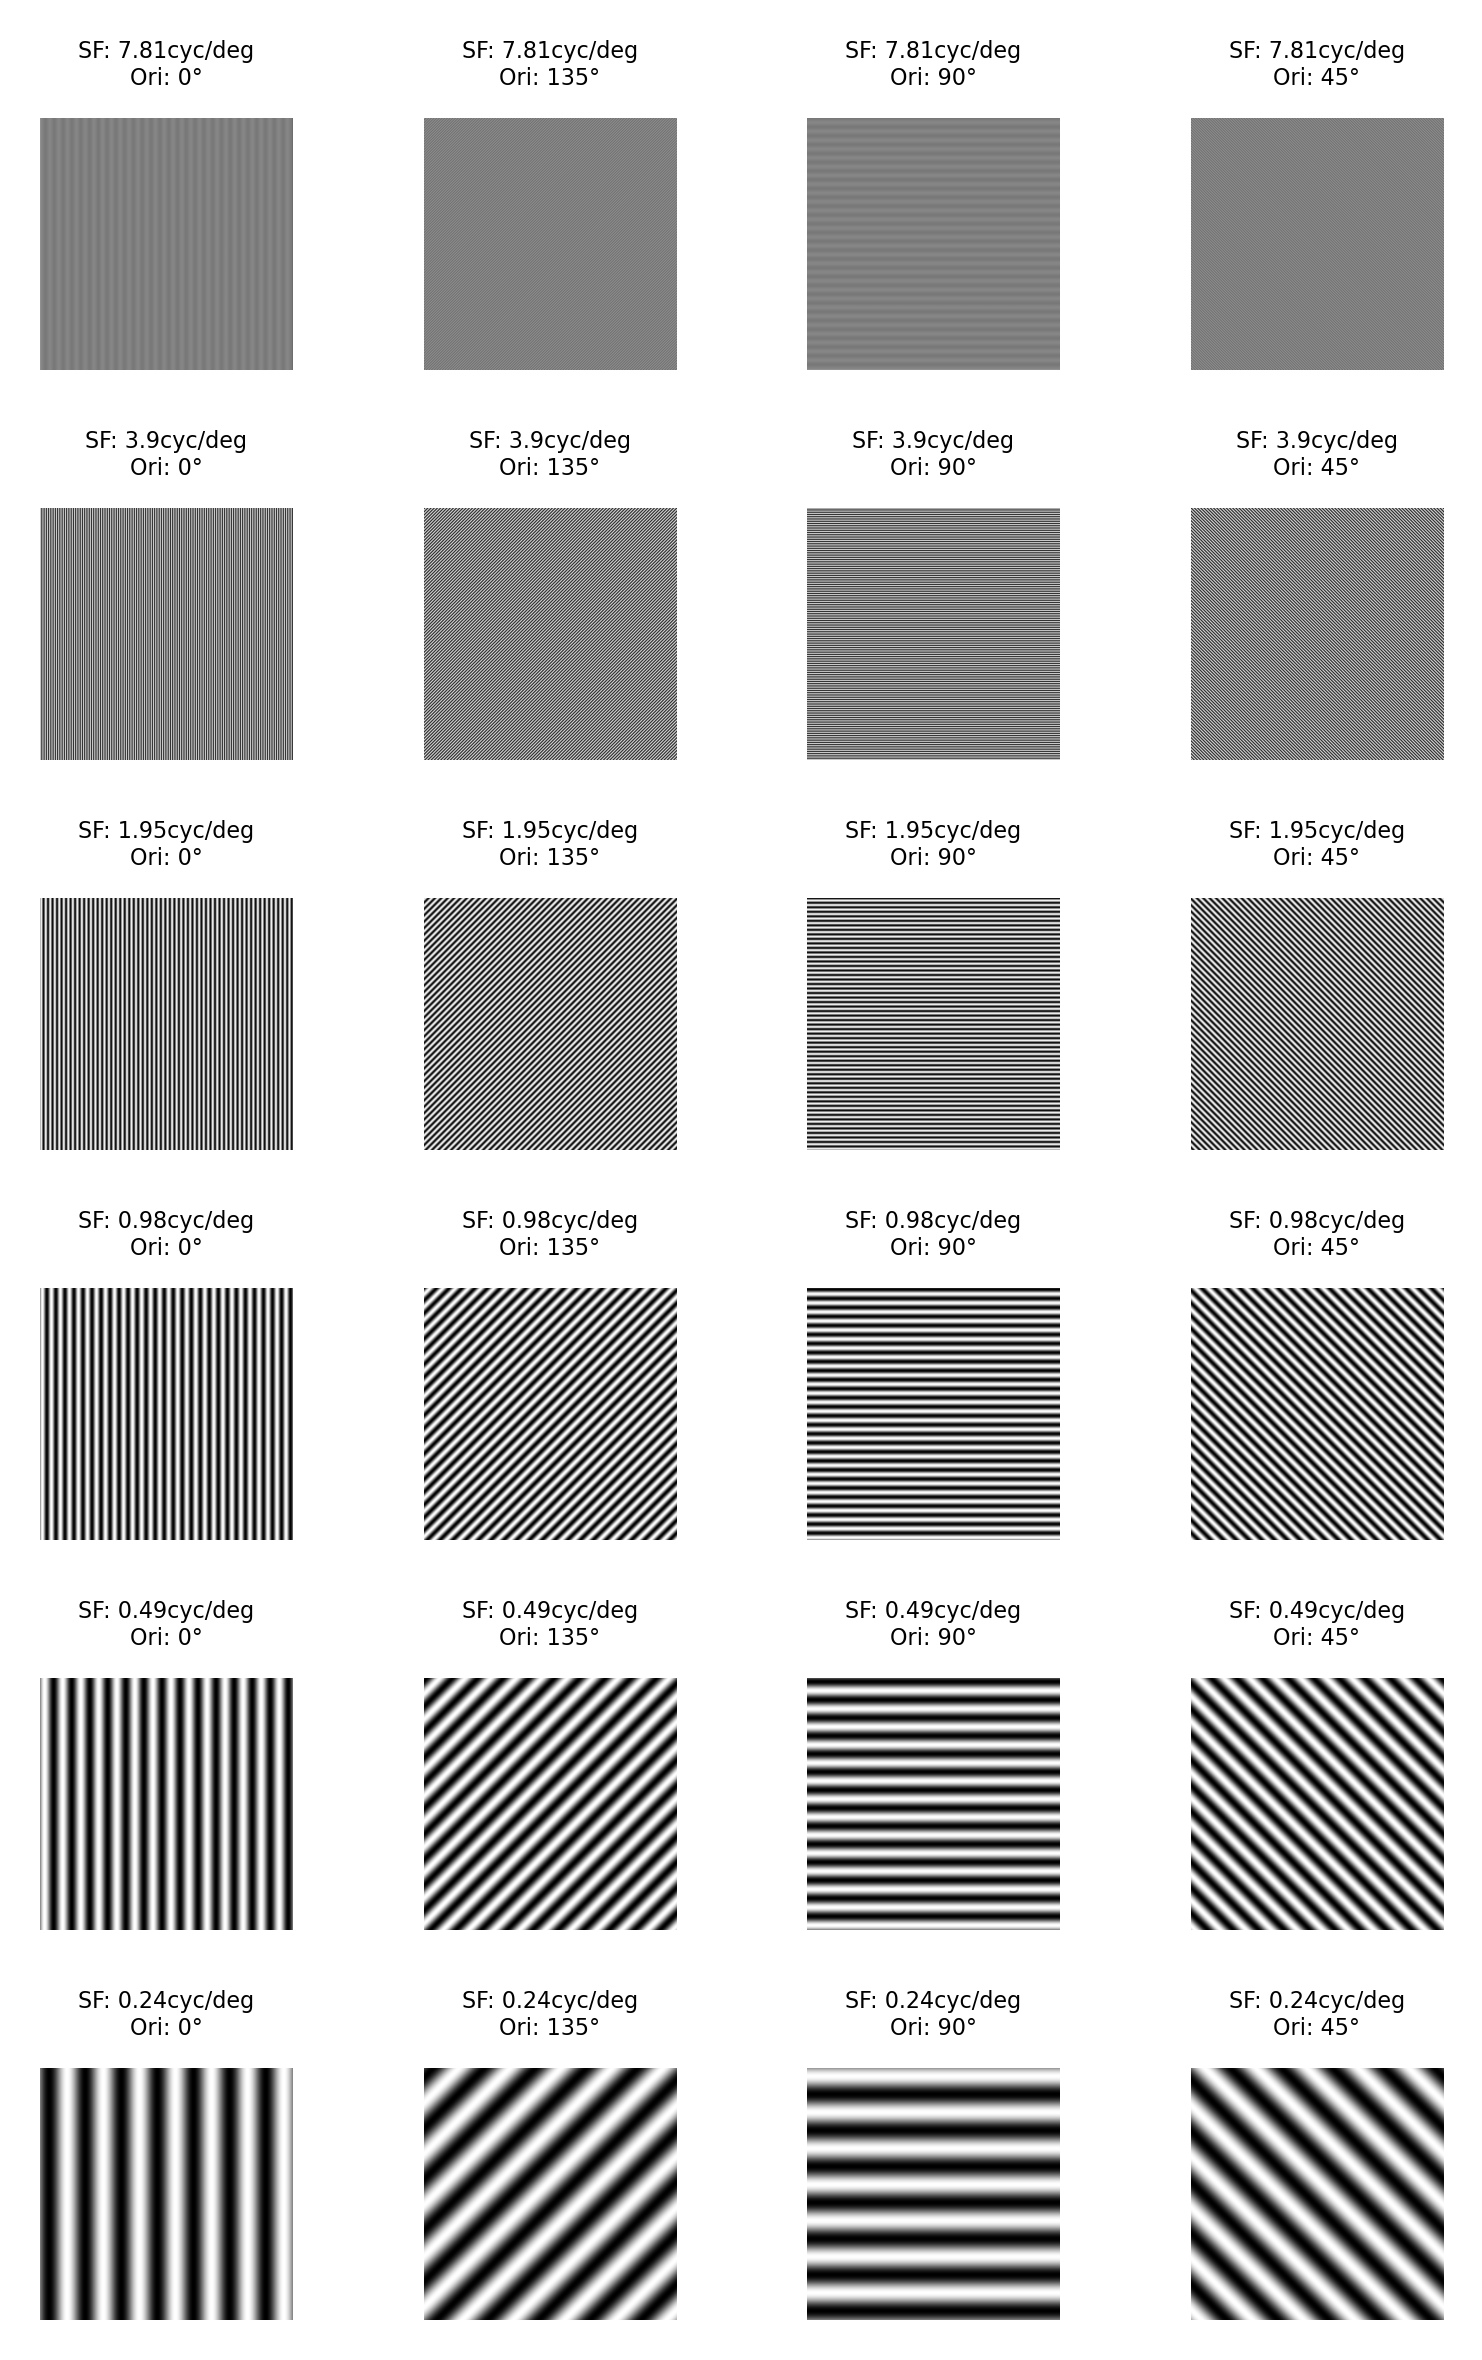

In [5]:
representative_chIdx = min(chSFs, key=lambda k: abs(chSFs[k] - 1)) # for later, this is idx closest to 1cyc/deg
optimal_stims = my_model.reconstruct_optimal_stimuli(visualize=True)

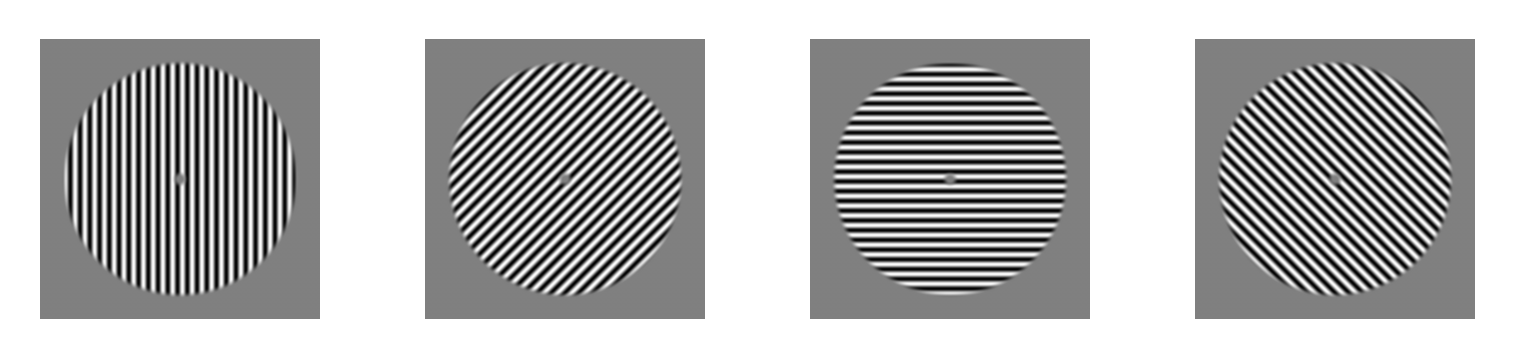

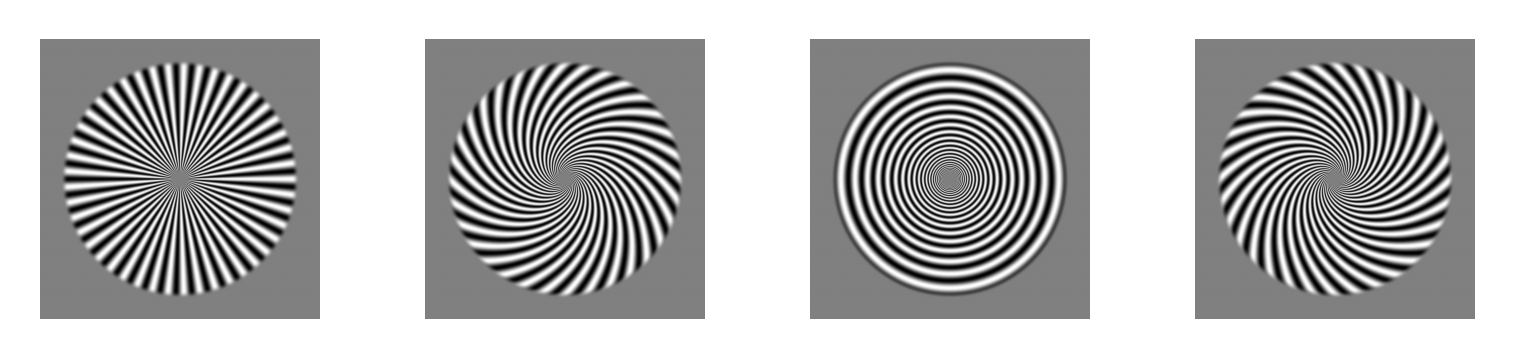

In [6]:
# Create input stimulus for the pyramid

sfs = np.array([1])               # cycles/deg
oris=np.array([0,135,90,45])      # degrees
stim = {}

for ri, ref in enumerate(["cartesian", "polar"]):
    stim[ri] = pyrmodel.InputStimuli(
        sfs=sfs,            
        oris=oris,
        img_size=img_size,
        img_degrees=padded_img_degrees,
        referenceframe=ref,
        mask=True,
        paddedBondaryPerc = exp_stim_diamDeg/padded_img_degrees
    )
    
    num_sf  = len(sfs)
    num_ori = len(oris)
    
    fig, axes = plt.subplots(num_sf, num_ori, figsize=(num_ori, num_sf), dpi=400)
    
    # force axes to always be 2D
    axes = np.atleast_2d(axes)
    
    for i, sf in enumerate(sfs):
        for j, ori in enumerate(oris):
            axes[i, j].imshow(stim[ri].input[i, j], cmap='gray', vmin=-1, vmax=1)
            axes[i, j].axis('off')
    plt.tight_layout()


In [7]:
# prepare stack of images to convert to tensor (preparing for pyramid)

# build numpy stack (dim0=set type, dim1=ori, dim2=X, dim3=Y)
arr = np.stack([
    np.stack([stim[i].input[(0,j)] for j in range(4)])
    for i in range(2)
])

input_tensor = torch.from_numpy(arr).float()
np.shape(input_tensor)

#po.imshow(input_tensor, batch_idx=0);
#po.imshow(input_tensor, batch_idx=1);

torch.Size([2, 4, 896, 896])

In [ ]:
#type(input_tensor)

In [8]:
dim_im = img_size

# build a steerable pyramid object
pyr = SteerablePyramidFreq(height=n_sf, 
                           image_shape=[dim_im, dim_im], 
                           order=3, is_complex=True,
                           tight_frame=True).to(
                           DEVICE
                           )

# pass the Tensor into the object
stim_coeffs = pyr(input_tensor)      # pass these stim inputs into pyramid

#stim_coeffs = my_model.forward(input_tensor)
print(stim_coeffs.keys())

# display output image per stimulus per channel
po.pyrshow(stim_coeffs, vrange='auto1', zoom=1, batch_idx=0) # first image of the batch (cartesian)
po.pyrshow(stim_coeffs, vrange='auto1', zoom=1, batch_idx=1); # second image of the batch (polar)

odict_keys(['residual_highpass', (0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3), (4, 0), (4, 1), (4, 2), (4, 3), (5, 0), (5, 1), (5, 2), (5, 3), 'residual_lowpass'])


In [9]:
all_data = []  # to store (sf, ori, batch, channel, energy_value)

for key, tensor in stim_coeffs.items():
    if isinstance(key, tuple):
        sf, ori = key
        for b in range(tensor.shape[0]):      # batch index
            for c in range(tensor.shape[1]):  # channel index
                img = tensor[b, c].abs() ** 2
                energy_value = img.mean().item()   # or .sum().item(), depending on what you want
                all_data.append([sf, ori, b, c, energy_value])
    else:
        continue  # skip residuals

# Convert list → NumPy array
all_data = np.array(all_data)  # shape [N, 5], columns = [sf, ori, batch, channel, energy]


In [11]:
#representative_chIdx

# ordered dictionary
#odict_keys(['residual_highpass', 
#(0, 0), (0, 1), (0, 2), (0, 3), 
#(1, 0), (1, 1), (1, 2), (1, 3), 
#(2, 0), (2, 1), (2, 2), (2, 3), 
#(3, 0), (3, 1), (3, 2), (3, 3), <----
#(4, 0), (4, 1), (4, 2), (4, 3), 
#(5, 0), (5, 1), (5, 2), (5, 3), 
#'residual_lowpass'])

# tmp = my_model.get_energy_of_filters(stim_coeffs, 
#                                          to_magnitude=True, 
#                                          to_numpy=True, 
#                                          reshape=True, 
#                                          normalize=False)

# for key, arr in stim_energy.items():
#     print(key, arr.shape)

Plot output of pyramid, with balanced ori channels
no scale given, so computing shared scale: global min/max


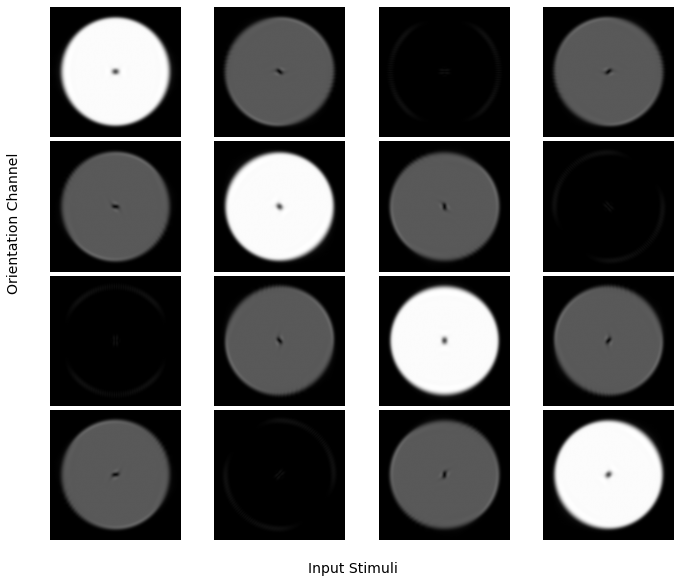

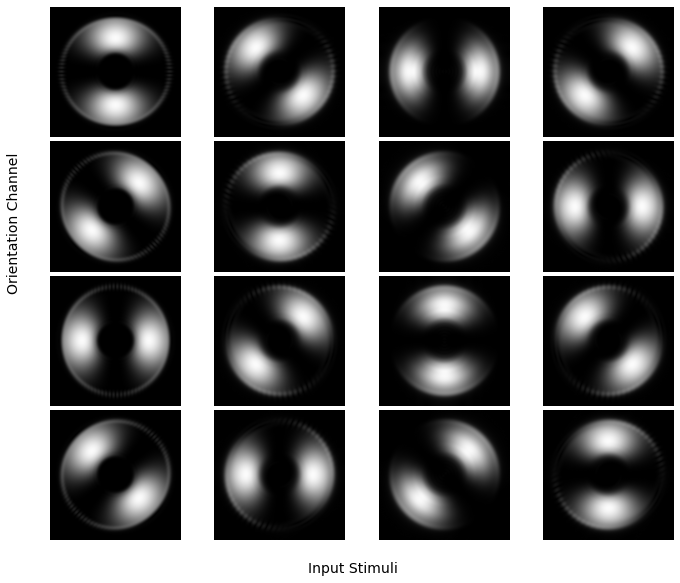

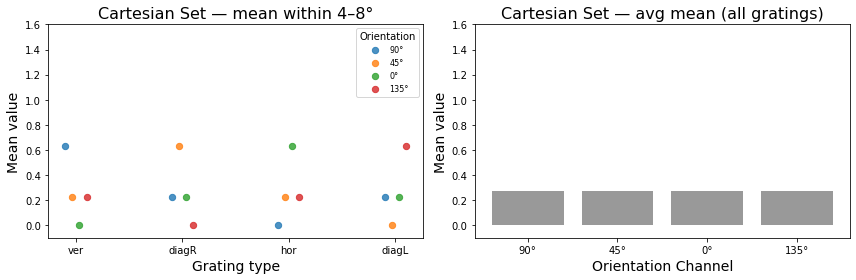

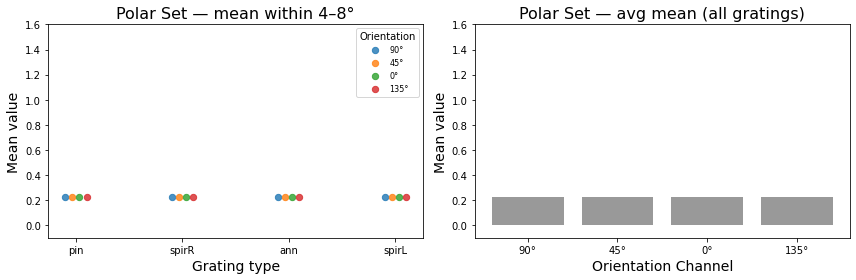

In [12]:
np.shape(input_tensor)

print('Plot output of pyramid, with balanced ori channels')

stim_energy = {}
n_set = 2
n_stimuli = 4

for i, j in product(range(n_set), range(n_stimuli)):
    stim_coeffs = my_model.forward(input_tensor[i, j, :, :])
    energy = my_model.get_energy_of_filters(stim_coeffs,
                                            to_magnitude=True,  # keep as magnitude, not energy (just prevents squaring)
                                            to_numpy=True,
                                            reshape=True,
                                            normalize=False)    # do not need to do this, due to tight pyramid?
    stim_energy[(i, j)] = energy

# my_model.visualize_filter_magnitudes(stim_energy, 
#                                      share_color_range=True, 
#                                      title='Optimal Stimuli E')


[scaleMin, scaleMax] = utils_image.visualize_filter_magnitudes(stim_energy, representative_chIdx, scale=None, share_color_range=True, title=None,
                                        cbar=False, scale_factor=3, save_path=None)

# calculate summed energy per channel per stimulus

utils_image.plot_energy_per_channel(stim_energy, representative_chIdx, pixpdeg, min_ecc_deg=4, max_ecc_deg=8, yrange=[-.1, 1.6])


Plot output of pyramid, with cardinal ori channels *2


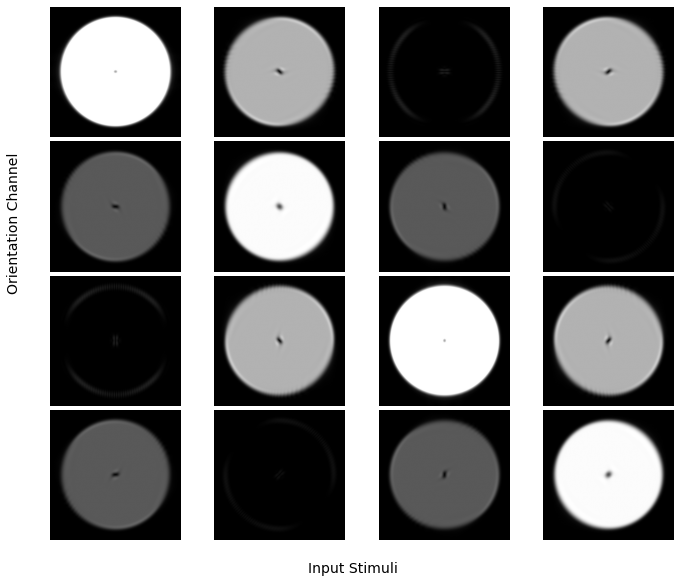

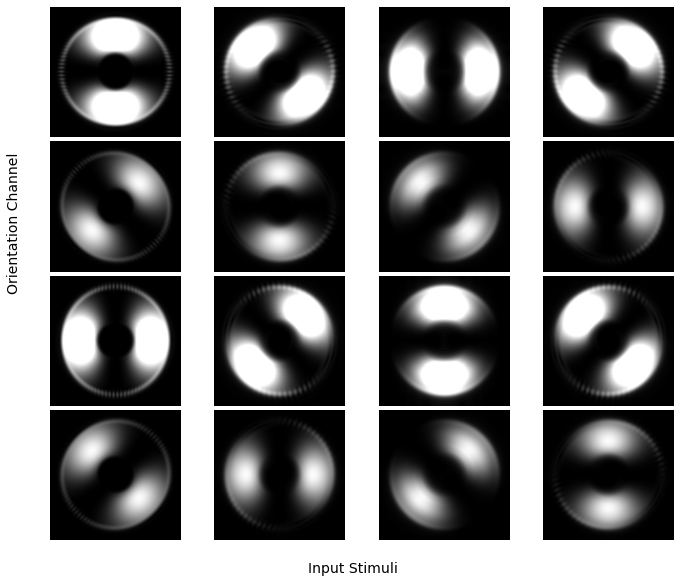

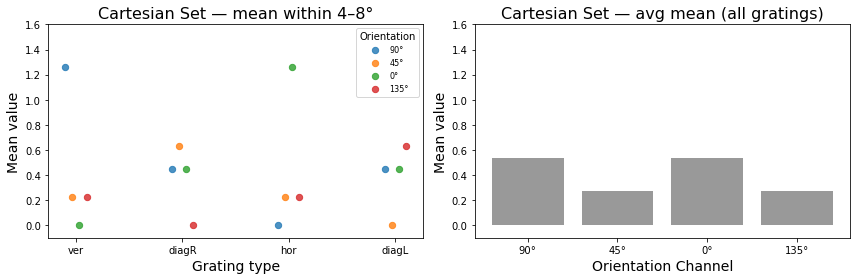

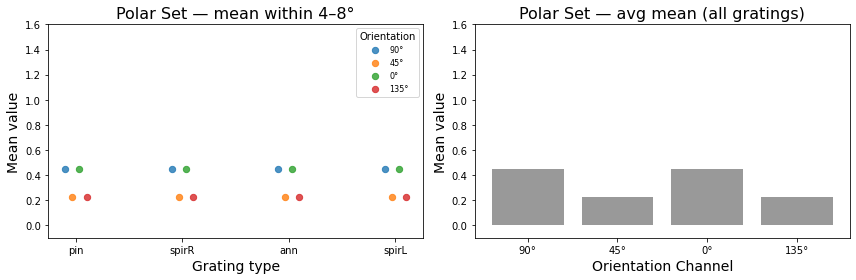

In [13]:
# create imbalanced population for a given channel
# by doubling energy for cartesian orientations

print('Plot output of pyramid, with cardinal ori channels *2')

stim_energy_imb = copy.deepcopy(stim_energy)

for i in range(n_set):             # e.g. Cartesian, Polar
    for j in range(n_stimuli):     # orientation
        stim_energy_imb[i, j][representative_chIdx, 0] *= 2
        stim_energy_imb[i, j][representative_chIdx, 2] *= 2

utils_image.visualize_filter_magnitudes(stim_energy_imb, representative_chIdx, [scaleMin, scaleMax], share_color_range=True, title=None,
                                        cbar=False, scale_factor=3, save_path=None)

utils_image.plot_energy_per_channel(stim_energy_imb, representative_chIdx, pixpdeg, min_ecc_deg=4, max_ecc_deg=8, yrange=[-.1, 1.6])

no scale given, so computing shared scale: global min/max


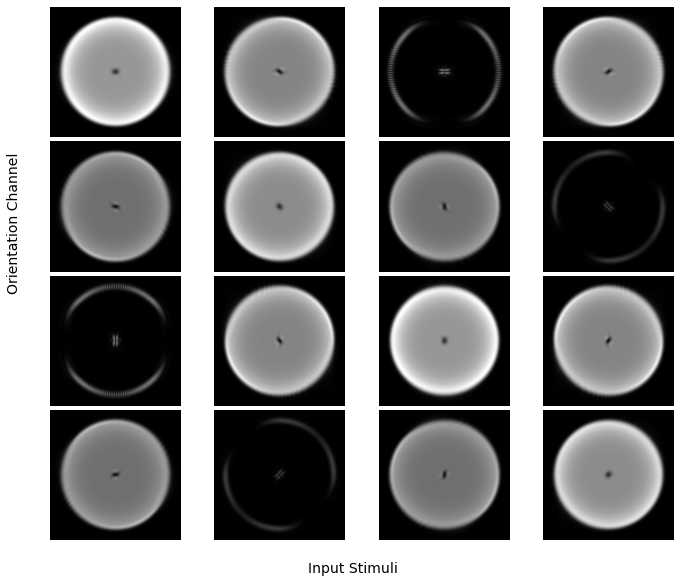

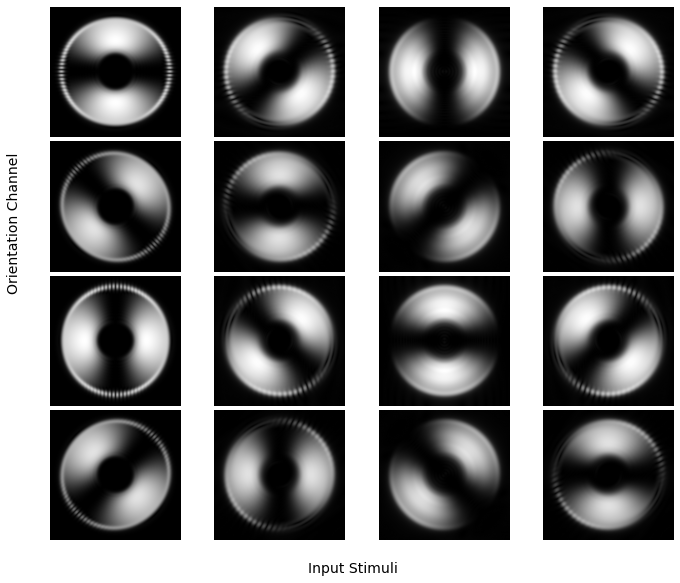

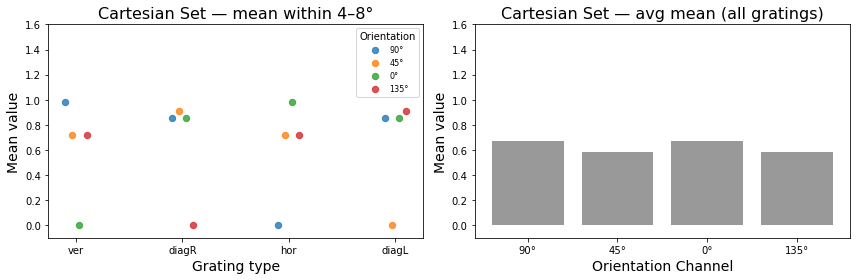

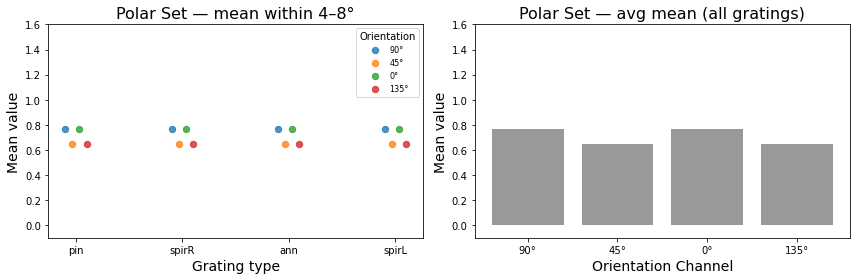

In [14]:
# spatial normalization

# sum across the SF dimension:

# stim_energy_imb_summedSF = {
#     key: np.sum(val, axis=0, keepdims=True)
#     for key, val in stim_energy_imb.items()
# }

# untuned_norm_energy = utils_image.canonical_normalization(stim_energy_imb_summedSF, pixpdeg, representative_chIdx=0, tuned=False)

# or keep it isolated to SF of interest
#stim_energy_imb_selectSF = stim_energy_imb

stim_energy_imb_selectSF = {
    key: arr[3:4, ...]     # slice keeps shape (1, 4, 896, 896)
    for key, arr in stim_energy_imb.items()
}

untuned_norm_energy = utils_image.canonical_normalization(stim_energy_imb_selectSF, pixpdeg, representative_chIdx=0, tuned=False)

utils_image.visualize_filter_magnitudes(untuned_norm_energy, 0, scale=None, share_color_range=True, title=None,
                                        cbar=False, scale_factor=3, save_path=None)

utils_image.plot_energy_per_channel(untuned_norm_energy, 0, pixpdeg, min_ecc_deg=4, max_ecc_deg=8, yrange=[-.1, 1.6]) #1.4])

In [16]:
# vmin = min(image.min() for image in orituned_norm_energy.values())  # Smallest value across all images
# vmax = max(image.max() for image in orituned_norm_energy.values())
# print(vmin)
# print(vmax)

no scale given, so computing shared scale: global min/max


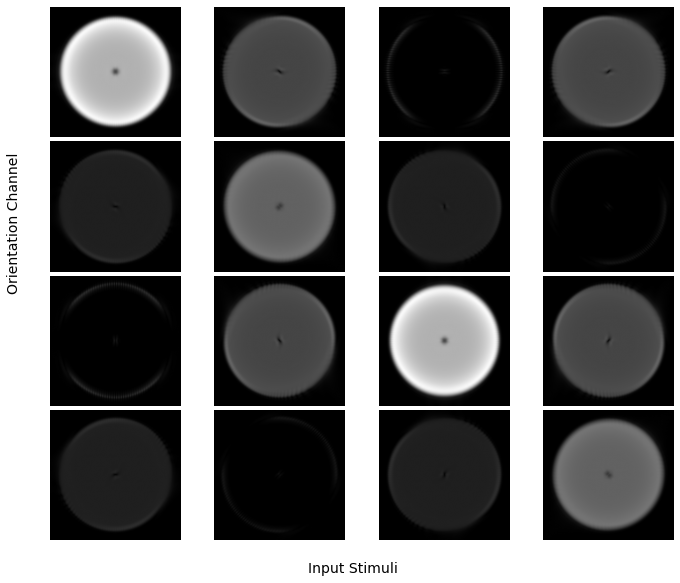

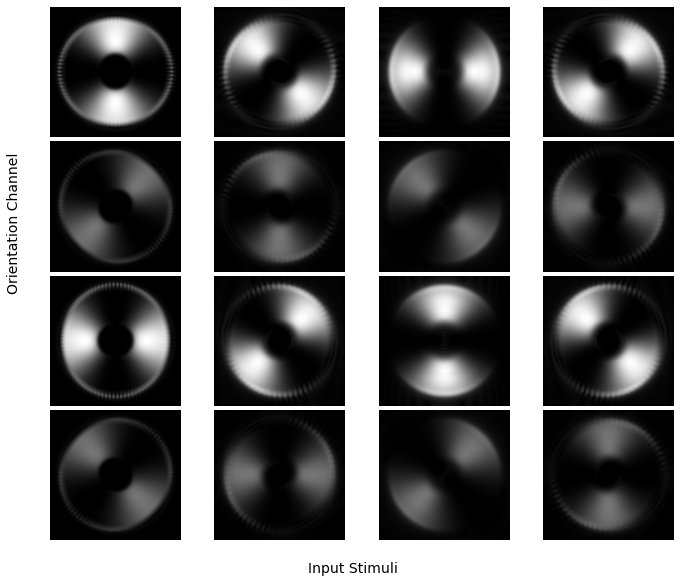

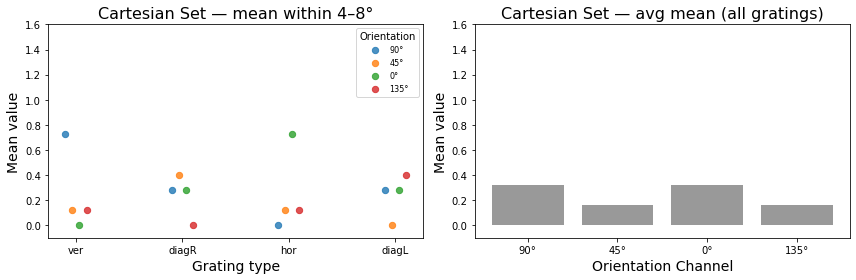

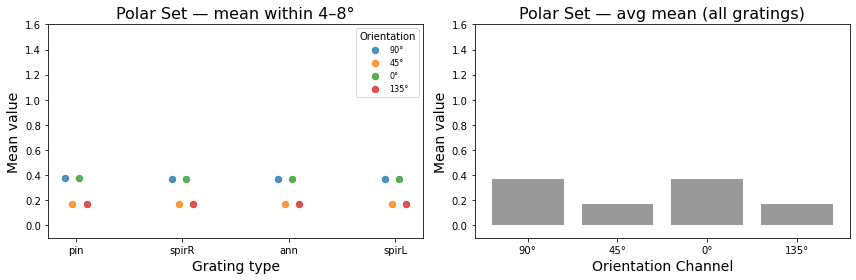

In [17]:
orituned_norm_energy = utils_image.canonical_normalization(stim_energy_imb_selectSF, pixpdeg, representative_chIdx=0, tuned=True)

utils_image.visualize_filter_magnitudes(orituned_norm_energy, 0, scale=None, share_color_range=True, title=None,
                                        cbar=False, scale_factor=3, save_path=None)

utils_image.plot_energy_per_channel(orituned_norm_energy, 0, pixpdeg, min_ecc_deg=4, max_ecc_deg=8, yrange=[-.1, 1.6])

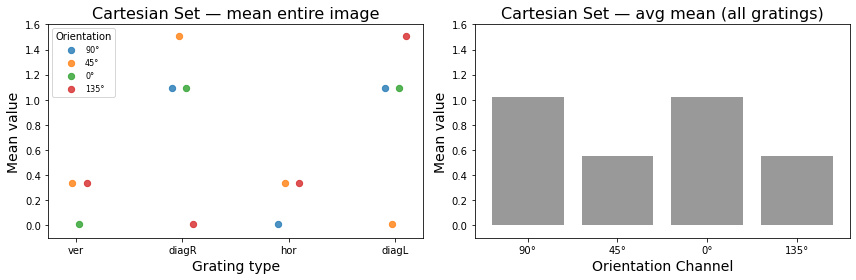

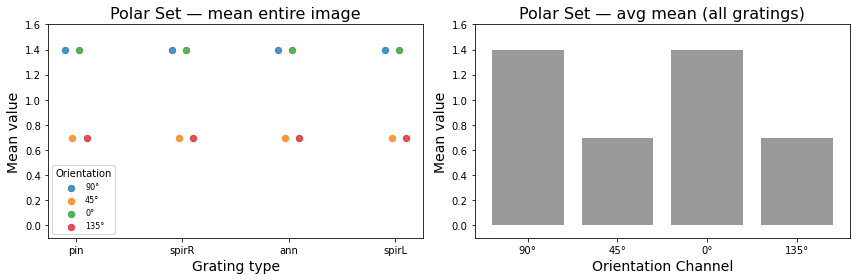

In [18]:
anisotropy_norm_energy = utils_image.normalization_byAnisotropy(stim_energy_imb_selectSF, pixpdeg)

anisotropy_norm_energy

utils_image.plot_energy_per_channel(anisotropy_norm_energy, 0, pixpdeg, yrange=[-.1, 1.6])

In [ ]:
# attempt to make images with anisotropy model -- needs to be re-coded

# anisotropy_norm_energy2 = utils_image.normalization_byAnisotropy_NOA(stim_energy_imb_selectSF, pixpdeg)

# utils_image.visualize_filter_magnitudes(anisotropy_norm_energy2, 0, scale=None, share_color_range=True, title=None,
#                                         cbar=False, scale_factor=3, save_path=None)

# utils_image.plot_energy_per_channel(anisotropy_norm_energy2, 0, pixpdeg, min_ecc_deg=4, max_ecc_deg=8, yrange=[-.1, 1])


In [ ]:
for key, arr in stim_energy.items():
    print(key, arr.shape)

In [ ]:
# to do:
# add the mask with cosine ramp
# check the magnitude output of each channel for each stimulus

# n_ori = 4
# n_sf = 6
# img_size = 854 # 854 results in SF channel of 1 cycle/deg
# my_model = pyrmodel.SteerablePyramidSF(n_ori=n_ori,
#                                        n_sf=n_sf,
#                                        img_size=img_size,
#                                        img_degrees=24.4,
#                                        is_complex=True,
#                                        downsample=False,
#                                        tight_frame=True,
#                                        device='cpu')